In [336]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42
import group_data as gd
verbose = True

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [337]:
####load the data
import h5py
cov_db_freq = h5py.File('../imaging_post_processing/cov_db_freq_sf.hdf5','a')
cov_db_amp = h5py.File('../imaging_post_processing/cov_db_amp_sf.hdf5','a')

In [338]:
################################################
# Function Defs
################################################

#### plotting code

def kill_spines(top = True,bottom =True, left = True,right=True):
    if top:
        plb.gca().spines['top'].set_visible(False)
        #[x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[1::2]]
    if right:
        plb.gca().spines['right'].set_visible(False)
        #[y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
    if left:
        plb.gca().spines['left'].set_visible(False)
        [y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]
    if bottom:
        plb.gca().spines['bottom'].set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[::2]]
        
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator

class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))
        
def plot_xcovf(mtrx,nolines = False,color = 'k'):
    """ plot a summary of cross covariance functions, pass mtrx which is a 
    n-fly by m-samples matrix of xcov functions to be summarized"""
    #mtrx = np.array(xcor_dta['xcor'])[selection]
    mn = np.mean(mtrx,axis = 0)
    md = np.nanpercentile(mtrx,50,axis = 0)
    ub = np.nanpercentile(mtrx,75,axis = 0)# mn + std
    lb = np.nanpercentile(mtrx,25,axis = 0)#mn - std
    xi = np.arange(0,shape(md)[0])*0.045
    xi -= xi[shape(md)[0]/2]
    xi *= -1

    fill_between(xi,ub,lb,color = color,alpha = 0.5,lw = 0)
    plot(xi,md,color = color,lw = 1.0)
    axvline(0,color = color,linestyle = ':')
    axhline(0,color = color,linestyle = ':')
    gca().set_xbound(-10,10)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    gca().spines['left'].set_position(('outward',10))
    gca().spines['bottom'].set_position(('outward',10))
    #[t.set_visible(False) for t in gca().get_yticklines()[1::2]]
    [t.set_visible(False) for t in gca().get_yticklines()[1::2]]
    [t.set_visible(False) for t in gca().get_xticklines()[1::2]]
    if nolines:
        gca().spines['left'].set_visible(False)
        gca().spines['bottom'].set_visible(False)
        [t.set_visible(False) for t in gca().get_yticklines()[::2]]
        [t.set_visible(False) for t in gca().get_xticklines()[::2]]
        [t.set_visible(False) for t in gca().get_yticklabels()[::2]]
        [t.set_visible(False) for t in gca().get_xticklabels()[::2]]
    gca().invert_xaxis()
    #mx = np.max(np.abs([np.nanmax(ub),np.nanmin(lb)]))
    #gca().set_ybound(-1*mx,mx)
    #gca().set_xbound(-2,2)
    #draw()
    #gca().set_yticks(gca().get_yticks()[-2:-1])
    return (md,ub,lb)


#stats functions
def resample_test(grp1,grp2,
                  test = lambda x,y: np.nanmean(x)-np.nanmean(y),
                  n = 10000):
    """construct a null distribution for a test statistic comparing group1 and group2"""
    from numpy.random import choice
    size1 = shape(grp1)[0]
    size2 = shape(grp2)[0]
    test_stats = list()
    datapool = hstack((grp1,grp2))
    #print shape(datapool)
    for t in range(n):
        test_stats.append(test(choice(datapool,size = size1),choice(datapool,size = size2)))
    return np.array(test_stats)

def resample_estimator(grp,estimator = np.median,n = 10000):
    """construct a distribution of resampled estimates for a population"""
    from numpy.random import choice
    size = shape(grp)[0]
    estimates = list()
    for est in range(n):
        estimates.append(estimator(choice(grp,size = size)))
    return np.array(estimates)
    
def bootstrap_p(grp1,grp2,test = lambda x,y: np.nanmean(x)-np.nanmean(y)):
    import numpy as np
    resamples = resample_test(grp1,grp2,test = test)
    tstat = test(grp1,grp2)
    pval = np.sum((abs(resamples) > abs(tstat))) / float(len(resamples))
    return pval

def calculate_grand_pvalue(test_muscle = 'b1',
                           cov_db = None,
                           null_dict = None,
                           peak_dict = None,
                           test_stat = np.mean,
                           observed_value = 0.0):
    """resample from the genotype-wise null distributions to construct a null distribution for the
    cross-driver line median, here driver line is considered a random variable"""
    line_keys = [k for k in cov_db.keys() if not('_GFP' in k)]
    tested_lines = np.array([k for k in line_keys if test_muscle in null_dict[k].keys()])
    num_lines = len(tested_lines)
    resamples = list()
    from numpy.random import choice
    for resample in range(20000):
        sample = list()
        for line in choice(tested_lines,size = num_lines,replace = True):
            sample.append(random.choice(null_dict[line][test_muscle]))
        resamples.append(test_stat(sample))
    return sum(np.abs(resamples)>np.abs(observed_value))/float(len(resamples))

def calculate_grand_estimate_dist(muscle = 'b1',case_ctrl = 'case',
                              sample_estimates = None,
                              peak_dict = None,
                              estimator = np.median,
                              line_keys = None):
    from numpy.random import choice
    tested_lines = np.array([k for k in line_keys if muscle in sample_estimates[k].keys()])
    if case_ctrl == 'case':
        tested_lines = np.array([k for k in tested_lines if not('_GFP' in k)])
    else:
        tested_lines = np.array([k for k in tested_lines if ('_GFP' in k)])
        
    num_lines = len(tested_lines)
    resamples = list()
    
    for resample in range(5000):
        sample = list()
        for line in choice(tested_lines,size = num_lines,replace = True):
            num_resamples = len(peak_dict[line][muscle])
            sample.append(estimator(choice(sample_estimates[line][muscle],size = num_resamples)))
        resamples.append(estimator(sample))
    return np.array(resamples)

def calculate_grand_estimate(muscle = 'b1',case_ctrl = 'case',
                             sample_estimates = None,
                             estimator = np.median,
                             line_keys = None,
                             cov_db = None,
                             peak_dict = None):
    
    from numpy.random import choice
    tested_lines = np.array([k for k in line_keys if muscle in sample_estimates[k].keys()])
    
    if case_ctrl == 'case':
        tested_lines = np.array([k for k in tested_lines if not('_GFP' in k)])
    else:
        tested_lines = np.array([k for k in tested_lines if ('_GFP' in k)])
    estimates = list()
    for line in tested_lines:
        estimates.append(estimator(peak_dict[line][muscle]))
    return estimator(estimates)

In [339]:
###################################################
# Stats for stroke dF/amplitude covariance
###################################################

### construct a dictionary of 'peak' covariance values for each genotype
if verbose: print('constructing peak dict')

peak_dict_amp = dict()
for swarm_name in cov_db_amp.keys():
    muscle_list = cov_db_amp[swarm_name].keys()
    peak_dict_amp[swarm_name] = dict()
    for mname in muscle_list:
        dtamtrx = np.array(cov_db_amp[swarm_name][mname])
        peak_idx = np.squeeze(argmax(abs(dtamtrx[:,:1150/2.0]),axis = 1))
        peak_data = diag(dtamtrx[:,peak_idx])
        peak_dict_amp[swarm_name][mname] = peak_data     
        
### construct distributions of the sample estimates  - muscle by genotype means
if verbose: print('constructing distributions of sample estimates')

sample_estimates_amp = dict()
for swarmkey in cov_db_amp.keys():
    sample_estimates_amp[swarmkey] = dict()
    for muscle in gd.muscle_plot_list:
        grp = peak_dict_amp[swarmkey][muscle]
        if not(sum(isnan(grp) > 0)):
            sample_estimates_amp[swarmkey][muscle] = resample_estimator(grp,estimator = np.mean,n = 10000)

### calculate grand estimates and confidence intervals for activity covariance with stroke amplitude 
if verbose: print('calculating grand estimates and confidence intervals')
CI = 95
up = 100 - (100-CI)/2.0
lp = (100-CI)/2.0

case_estimate_dict_amp = dict()
for muscle in gd.muscle_plot_list:
    case_estimate_dict_amp[muscle] = dict()
    case_estimate_dict_amp[muscle]['sample_distribution'] = calculate_grand_estimate_dist(muscle = muscle,
                                                                 sample_estimates = sample_estimates_amp,
                                                                 peak_dict = peak_dict_amp,
                                                                 line_keys = cov_db_amp.keys(),
                                                                 estimator = np.mean)
    
    case_estimate_dict_amp[muscle]['estimate'] = calculate_grand_estimate(muscle = muscle,
                                                                      peak_dict = peak_dict_amp,
                                                                      sample_estimates = sample_estimates_amp,
                                                                      line_keys = cov_db_amp.keys(),
                                                                      estimator = np.mean)
    case_estimate_dict_amp[muscle]['ub'] = np.percentile(case_estimate_dict_amp[muscle]['sample_distribution'],up)
    case_estimate_dict_amp[muscle]['lb'] = np.percentile(case_estimate_dict_amp[muscle]['sample_distribution'],lp)
    
ctrl_estimate_dict_amp = dict()
for muscle in gd.muscle_plot_list:
    ctrl_estimate_dict_amp[muscle] = dict()
    ctrl_estimate_dict_amp[muscle]['sample_distribution'] = calculate_grand_estimate_dist(muscle = muscle,
                                                                 sample_estimates = sample_estimates_amp,
                                                                 peak_dict = peak_dict_amp,
                                                                 line_keys = cov_db_amp.keys(),
                                                                 estimator = np.mean,
                                                                 case_ctrl = 'ctrl')
    
    ctrl_estimate_dict_amp[muscle]['estimate'] = calculate_grand_estimate(muscle = muscle,
                                                                      estimator = np.mean,
                                                                      peak_dict = peak_dict_amp,
                                                                      sample_estimates = sample_estimates_amp,
                                                                      line_keys = cov_db_amp.keys(),
                                                                      case_ctrl = 'ctrl')
    ctrl_estimate_dict_amp[muscle]['ub'] = np.percentile(ctrl_estimate_dict_amp[muscle]['sample_distribution'],up)
    ctrl_estimate_dict_amp[muscle]['lb'] = np.percentile(ctrl_estimate_dict_amp[muscle]['sample_distribution'],lp)

### Re-organize the data a bit for plotting
case_lb_amp = list()
case_ub_amp = list()
case_md_amp = list()
for muscle in gd.muscle_plot_list:
    case_ub_amp.append(case_estimate_dict_amp[muscle]['ub']-case_estimate_dict_amp[muscle]['estimate'])
    case_lb_amp.append(case_estimate_dict_amp[muscle]['estimate'] - case_estimate_dict_amp[muscle]['lb'])
    case_md_amp.append(case_estimate_dict_amp[muscle]['estimate'])
    
ctrl_lb_amp = list()
ctrl_ub_amp = list()
ctrl_md_amp = list()
for muscle in gd.muscle_plot_list:
    ctrl_ub_amp.append(ctrl_estimate_dict_amp[muscle]['ub']-ctrl_estimate_dict_amp[muscle]['estimate'])
    ctrl_lb_amp.append(ctrl_estimate_dict_amp[muscle]['estimate'] - ctrl_estimate_dict_amp[muscle]['lb'])
    ctrl_md_amp.append(ctrl_estimate_dict_amp[muscle]['estimate'])

### now resample to find the null distributions and p-values broken down muscle by genotype
if verbose: print('calculating null distributions for test statistics and p-values for each genotype')

test_dict_amp = dict()
null_dict_amp = dict()
test = lambda x,y: np.mean(x)-np.mean(y)

for swarmkey in [k for k in cov_db_amp.keys() if not('_GFP' in k)]:
    #print swarmkey
    null_dict_amp[swarmkey] = dict()
    test_dict_amp[swarmkey] = dict()
    for key in gd.muscle_plot_list:
        grp1 = peak_dict_amp[swarmkey][key]
        grp2 = peak_dict_amp[swarmkey + '_GFP'][key]
        if not(sum(isnan(grp1) > 0)):
            null_dict_amp[swarmkey][key] = resample_test(grp1,grp2,test = test)
            test_dict_amp[swarmkey][key] = bootstrap_p(grp1,grp2,test = test)
            
### resample from genotype distributions of test statistis to calculate the accross group p-values
if verbose: print('calculating grand p-value for each muscle')

pval_dict_amp = dict()
for muscle in gd.muscle_plot_list:
    pval = calculate_grand_pvalue(test_muscle = muscle,
                               cov_db = cov_db_amp,
                               null_dict = null_dict_amp,
                               peak_dict = peak_dict_amp,
                               test_stat = np.mean,
                               observed_value = case_estimate_dict_amp[muscle]['estimate'] - \
                                  ctrl_estimate_dict_amp[muscle]['estimate'])
    pval_dict_amp[muscle] = pval

constructing peak dict
constructing distributions of sample estimates
calculating grand estimates and confidence intervals
calculating null distributions for test statistics and p-values for each genotype
calculating grand p-value for each muscle


In [342]:
test_dict_amp['GMR22H05']

{'b1': 0.1724,
 'b2': 0.17810000000000001,
 'b3': 0.13020000000000001,
 'hg1': 0.067100000000000007,
 'hg2': 0.7661,
 'hg3': 0.373,
 'hg4': 0.27610000000000001,
 'i1': 0.092600000000000002,
 'i2': 0.80489999999999995,
 'iii1': 0.14560000000000001,
 'iii24': 0.037900000000000003,
 'iii3': 0.037999999999999999,
 'pr': 0.35649999999999998,
 'tpd': 0.10639999999999999,
 'tpv': 0.37509999999999999,
 'ttm': 0.87419999999999998}

In [353]:
test_dict_freq['GMR22H05']

{'b1': 0.29880000000000001,
 'b2': 0.44319999999999998,
 'b3': 0.41249999999999998,
 'hg1': 0.38400000000000001,
 'hg2': 0.31680000000000003,
 'hg3': 0.47289999999999999,
 'hg4': 0.69430000000000003,
 'i1': 0.39639999999999997,
 'i2': 0.38469999999999999,
 'iii1': 0.49890000000000001,
 'iii24': 0.754,
 'iii3': 0.29509999999999997,
 'pr': 0.4667,
 'tpd': 0.12520000000000001,
 'tpv': 0.2979,
 'ttm': 0.33529999999999999}

(22,)
(7,)


In [356]:
ttest_ind(peak_dict_amp['GMR22H05']['iii3'],peak_dict_amp['GMR22H05_GFP']['iii3'])

(2.1470147088488414, 0.040930895429189255)

In [340]:
###################################################
# Stats for dF:frequency covariance
###################################################

### construct a dictionary of 'peak' covariance values for each genotype
if verbose: print('constructing peak dict')

peak_dict_freq = dict()
for swarm_name in cov_db_freq.keys():
    muscle_list = cov_db_freq[swarm_name].keys()
    peak_dict_freq[swarm_name] = dict()
    for mname in muscle_list:
        dtamtrx = np.array(cov_db_freq[swarm_name][mname])
        peak_idx = np.squeeze(argmax(abs(dtamtrx[:,:1150/2.0]),axis = 1))
        peak_data = diag(dtamtrx[:,peak_idx])
        peak_dict_freq[swarm_name][mname] = peak_data     
        
### construct distributions of the sample estimates  - muscle by genotype means
if verbose: print('constructing distributions of sample estimates')

sample_estimates_freq = dict()
for swarmkey in cov_db_freq.keys():
    sample_estimates_freq[swarmkey] = dict()
    for muscle in gd.muscle_plot_list:
        grp = peak_dict_freq[swarmkey][muscle]
        if not(sum(isnan(grp) > 0)):
            sample_estimates_freq[swarmkey][muscle] = resample_estimator(grp,estimator = np.mean,n = 10000)

### calculate grand estimates and confidence intervals for activity covariance with stroke amplitude 
if verbose: print('calculating grand estimates and confidence intervals')
CI = 95
up = 100 - (100-CI)/2.0
lp = (100-CI)/2.0

case_estimate_dict_freq = dict()
for muscle in gd.muscle_plot_list:
    case_estimate_dict_freq[muscle] = dict()
    case_estimate_dict_freq[muscle]['sample_distribution'] = calculate_grand_estimate_dist(muscle = muscle,
                                                                 sample_estimates = sample_estimates_freq,
                                                                 peak_dict = peak_dict_freq,
                                                                 line_keys = cov_db_freq.keys(),
                                                                 estimator = np.mean)
    
    case_estimate_dict_freq[muscle]['estimate'] = calculate_grand_estimate(muscle = muscle,
                                                                      peak_dict = peak_dict_freq,
                                                                      sample_estimates = sample_estimates_freq,
                                                                      line_keys = cov_db_freq.keys(),
                                                                      estimator = np.mean)
    case_estimate_dict_freq[muscle]['ub'] = np.percentile(case_estimate_dict_freq[muscle]['sample_distribution'],up)
    case_estimate_dict_freq[muscle]['lb'] = np.percentile(case_estimate_dict_freq[muscle]['sample_distribution'],lp)
    
ctrl_estimate_dict_freq = dict()
for muscle in gd.muscle_plot_list:
    ctrl_estimate_dict_freq[muscle] = dict()
    ctrl_estimate_dict_freq[muscle]['sample_distribution'] = calculate_grand_estimate_dist(muscle = muscle,
                                                                 sample_estimates = sample_estimates_freq,
                                                                 peak_dict = peak_dict_freq,
                                                                 line_keys = cov_db_freq.keys(),
                                                                 estimator = np.mean,
                                                                 case_ctrl = 'ctrl')
    
    ctrl_estimate_dict_freq[muscle]['estimate'] = calculate_grand_estimate(muscle = muscle,
                                                                      estimator = np.mean,
                                                                      peak_dict = peak_dict_freq,
                                                                      sample_estimates = sample_estimates_freq,
                                                                      line_keys = cov_db_freq.keys(),
                                                                      case_ctrl = 'ctrl')
    ctrl_estimate_dict_freq[muscle]['ub'] = np.percentile(ctrl_estimate_dict_freq[muscle]['sample_distribution'],up)
    ctrl_estimate_dict_freq[muscle]['lb'] = np.percentile(ctrl_estimate_dict_freq[muscle]['sample_distribution'],lp)

### Re-organize the data a bit for plotting
case_lb_freq = list()
case_ub_freq = list()
case_md_freq = list()
for muscle in gd.muscle_plot_list:
    case_ub_freq.append(case_estimate_dict_freq[muscle]['ub']-case_estimate_dict_freq[muscle]['estimate'])
    case_lb_freq.append(case_estimate_dict_freq[muscle]['estimate'] - case_estimate_dict_freq[muscle]['lb'])
    case_md_freq.append(case_estimate_dict_freq[muscle]['estimate'])
    
ctrl_lb_freq = list()
ctrl_ub_freq = list()
ctrl_md_freq = list()
for muscle in gd.muscle_plot_list:
    ctrl_ub_freq.append(ctrl_estimate_dict_freq[muscle]['ub']-ctrl_estimate_dict_freq[muscle]['estimate'])
    ctrl_lb_freq.append(ctrl_estimate_dict_freq[muscle]['estimate'] - ctrl_estimate_dict_freq[muscle]['lb'])
    ctrl_md_freq.append(ctrl_estimate_dict_freq[muscle]['estimate'])

### now resample to find the null distributions and p-values broken down muscle by genotype
if verbose: print('calculating null distributions for test statistics and p-values for each genotype')

test_dict_freq = dict()
null_dict_freq = dict()
test = lambda x,y: np.mean(x)-np.mean(y)

for swarmkey in [k for k in cov_db_freq.keys() if not('_GFP' in k)]:
    #print swarmkey
    null_dict_freq[swarmkey] = dict()
    test_dict_freq[swarmkey] = dict()
    for key in gd.muscle_plot_list:
        grp1 = peak_dict_freq[swarmkey][key]
        grp2 = peak_dict_freq[swarmkey + '_GFP'][key]
        if not(sum(isnan(grp1) > 0)):
            null_dict_freq[swarmkey][key] = resample_test(grp1,grp2,test = test)
            test_dict_freq[swarmkey][key] = bootstrap_p(grp1,grp2,test = test)
            
### resample from genotype distributions of test statistis to calculate the accross group p-values
if verbose: print('calculating grand p-value for each muscle')

pval_dict_freq = dict()
for muscle in gd.muscle_plot_list:
    pval = calculate_grand_pvalue(test_muscle = muscle,
                               cov_db = cov_db_freq,
                               null_dict = null_dict_freq,
                               peak_dict = peak_dict_freq,
                               test_stat = np.mean,
                               observed_value = case_estimate_dict_freq[muscle]['estimate'] - \
                                  ctrl_estimate_dict_freq[muscle]['estimate'])
    pval_dict_freq[muscle] = pval

constructing peak dict
constructing distributions of sample estimates
calculating grand estimates and confidence intervals
calculating null distributions for test statistics and p-values for each genotype
calculating grand p-value for each muscle


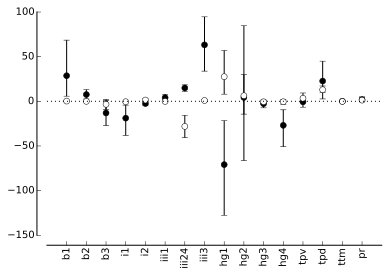

In [280]:
errorbar(arange(len(case_md_amp)),case_md_amp,yerr = vstack((case_lb_amp,case_ub_amp)),marker = 'o',ls = 'none',color = 'k')
errorbar(arange(len(ctrl_md_amp)),ctrl_md_amp,yerr = vstack((ctrl_lb_amp,ctrl_ub_amp)),marker = 'o',markerfacecolor = 'w',ls = 'none',color = 'k')
axhline(0,ls = ':',color = 'k')
gca().set_xbound(-1,16)
lbs = gca().set_xticks(arange(len(gd.muscle_plot_list)))
gca().spines['left'].set_position(('outward',10))
gca().spines['bottom'].set_position(('outward',10))
kill_spines(left = False,bottom = False)
lbs = gca().set_xticklabels(gd.muscle_plot_list,rotation = 90)
savefig('amp_group_summary.pdf')

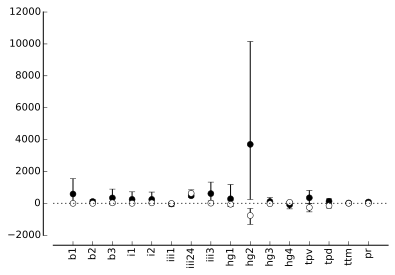

In [278]:
errorbar(arange(len(case_md_freq)),case_md_freq,yerr = vstack((case_lb_freq,case_ub_freq)),marker = 'o',ls = 'none',color = 'k')
errorbar(arange(len(ctrl_md_freq)),ctrl_md_freq,yerr = vstack((ctrl_lb_freq,ctrl_ub_freq)),marker = 'o',markerfacecolor = 'w',ls = 'none',color = 'k')
axhline(0,ls = ':',color = 'k')
gca().set_xbound(-1,16)
lbs = gca().set_xticks(arange(len(gd.muscle_plot_list)))
gca().spines['left'].set_position(('outward',10))
gca().spines['bottom'].set_position(('outward',10))
kill_spines(left = False,bottom = False)
lbs = gca().set_xticklabels(gd.muscle_plot_list,rotation = 90)
savefig('frequency_group_summary.pdf')

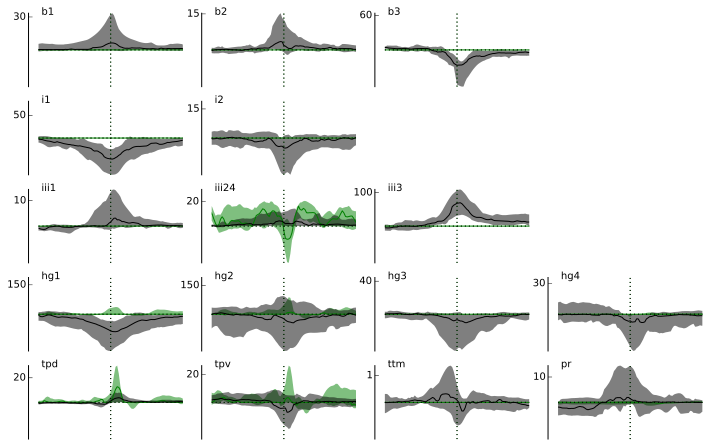

In [334]:
###########################################################################
## cross covariance functions of muscle activation and stroke amplitude
############################################################################
fig = figure(figsize = (15,25))
gs = GridSpec(len(gd.muscle_plot_list),5)
xcorr_pans = dict()

xcorr_pans['b1'] = fig.add_subplot(gs[0,0:1])
xcorr_pans['b2'] = fig.add_subplot(gs[0,1:2])
xcorr_pans['b3'] = fig.add_subplot(gs[0,2:3])

xcorr_pans['i1'] = fig.add_subplot(gs[1,0:1])
xcorr_pans['i2'] = fig.add_subplot(gs[1,1:2])

xcorr_pans['iii1'] = fig.add_subplot(gs[2,0:1])
xcorr_pans['iii24'] = fig.add_subplot(gs[2,1:2])
xcorr_pans['iii3'] = fig.add_subplot(gs[2,2:3])

xcorr_pans['hg1'] = fig.add_subplot(gs[3,0:1])
xcorr_pans['hg2'] = fig.add_subplot(gs[3,1:2])
xcorr_pans['hg3'] = fig.add_subplot(gs[3,2:3])
xcorr_pans['hg4'] = fig.add_subplot(gs[3,3:4])

xcorr_pans['tpd'] = fig.add_subplot(gs[4,0:1])
xcorr_pans['tpv'] = fig.add_subplot(gs[4,1:2])
xcorr_pans['ttm'] = fig.add_subplot(gs[4,2:3])
xcorr_pans['pr'] = fig.add_subplot(gs[4,3:4])

for i,muscle in enumerate(gd.muscle_plot_list):
    axes(xcorr_pans[muscle])
    md1,ub1,lb1 = plot_xcovf(cov_db_amp['GMR22H05_GFP'][muscle],color = 'g')# cm.Blues(0.9))
    md2,ub2,lb2 = plot_xcovf(cov_db_amp['GMR22H05'][muscle],color = 'k')
    
    mx = np.max(np.abs([np.nanmax(ub1),np.nanmin(lb1),np.nanmax(ub2),np.nanmin(lb2)]))

    gca().spines['bottom'].set_visible(False)
    [t.set_visible(False) for t in gca().get_xticklines()]
    [t.set_visible(False) for t in gca().get_xticklabels()]
    gca().annotate(muscle, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
                horizontalalignment='left', verticalalignment='bottom')
    
    gca().set_ybound(-1*mx,mx)
    gca().set_xbound(-2,2)
    
    gca().set_yticks(gca().get_yticks()[-2:-1])
    draw()
    
savefig('xcor_example_amp.pdf')

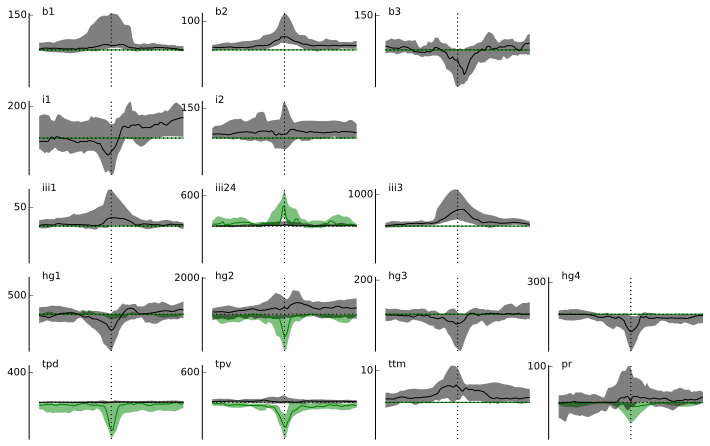

In [335]:
###########################################################################
## cross covariance functions of muscle activation and stroke frequency
############################################################################
fig = figure(figsize = (15,25))
gs = GridSpec(len(gd.muscle_plot_list),5)
xcorr_pans = dict()

xcorr_pans['b1'] = fig.add_subplot(gs[0,0:1])
xcorr_pans['b2'] = fig.add_subplot(gs[0,1:2])
xcorr_pans['b3'] = fig.add_subplot(gs[0,2:3])

xcorr_pans['i1'] = fig.add_subplot(gs[1,0:1])
xcorr_pans['i2'] = fig.add_subplot(gs[1,1:2])

xcorr_pans['iii1'] = fig.add_subplot(gs[2,0:1])
xcorr_pans['iii24'] = fig.add_subplot(gs[2,1:2])
xcorr_pans['iii3'] = fig.add_subplot(gs[2,2:3])

xcorr_pans['hg1'] = fig.add_subplot(gs[3,0:1])
xcorr_pans['hg2'] = fig.add_subplot(gs[3,1:2])
xcorr_pans['hg3'] = fig.add_subplot(gs[3,2:3])
xcorr_pans['hg4'] = fig.add_subplot(gs[3,3:4])

xcorr_pans['tpd'] = fig.add_subplot(gs[4,0:1])
xcorr_pans['tpv'] = fig.add_subplot(gs[4,1:2])
xcorr_pans['ttm'] = fig.add_subplot(gs[4,2:3])
xcorr_pans['pr'] = fig.add_subplot(gs[4,3:4])

for i,muscle in enumerate(gd.muscle_plot_list):
    axes(xcorr_pans[muscle])
    md1,ub1,lb1 = plot_xcovf(cov_db_freq['GMR22H05_GFP'][muscle],color = 'g')# cm.Blues(0.9))
    md2,ub2,lb2 = plot_xcovf(cov_db_freq['GMR22H05'][muscle],color = 'k')
    
    mx = np.max(np.abs([np.nanmax(ub1),np.nanmin(lb1),np.nanmax(ub2),np.nanmin(lb2)]))

    gca().spines['bottom'].set_visible(False)
    [t.set_visible(False) for t in gca().get_xticklines()]
    [t.set_visible(False) for t in gca().get_xticklabels()]
    gca().annotate(muscle, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
                horizontalalignment='left', verticalalignment='bottom')
    
    gca().set_ybound(-1*mx,mx)
    gca().set_xbound(-2,2)
    
    gca().set_yticks(gca().get_yticks()[-2:-1])
    draw()
savefig('xcor_example_freq.pdf')

In [181]:
gmrlines = [key for key in ['GMR22H05',
                                           'GMR10A12',
                                           'GMR74F03',
                                           'GMR75B06',
                                           'GMR29E05',
                                           'GMR31E10',
                                           'GMR39E01']]

ctrllines = [key + '_GFP' for key in ['GMR22H05',
                                           'GMR10A12',
                                           'GMR74F03',
                                           'GMR75B06',
                                           'GMR29E05',
                                           'GMR31E10',
                                           'GMR39E01']]

def make_stats_summary(peak_dict = None,
                      muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm','pr']):
    fig = plb.figure(figsize = (10,11))
    #muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm','pr']
    cmap = plb.cm.spectral
    
    panlist = list()
    
    from matplotlib import gridspec
    #gs = GridSpec(4,len(muscle_list))
    gs = GridSpec(len(muscle_list),4)
    
    fig.add_subplot(gs[:,0:3])
    axvspan(-10,10,alpha = 0.1,lw = 0,color = 'k')
    gca().set_xscale('symlog',linthreshx = 10,basex = 10)
    gca().set_xbound(-1*10**3,10**3)
    kill_spines()
    gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
    
    fig.add_subplot(gs[:,3:4])
    axvspan(-10,10,alpha = 0.1,lw = 0,color = 'k')
    gca().set_xscale('symlog',linthreshx = 10,basex = 10)
    gca().set_xbound(-1*10**1-1,10**1+1)
    kill_spines()
    gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
    
    #xcorr_pans = list()
    #xcorr_pans.append(fig.add_subplot(gs[0,0:1]))
    #for i,m in enumerate(muscle_list[1:]):
    #    xcorr_pans.append(fig.add_subplot(gs[i+1,0:1],sharex = plb.gca()))
    
    pans = list()
    pans.append(fig.add_subplot(gs[0,0:3]))
    for i,m in enumerate(muscle_list[1:]):
        pans.append(fig.add_subplot(gs[i+1,0:3],sharey = plb.gca(),sharex = plb.gca()))
    
    pans_ctrl = list()
    pans_ctrl.append(fig.add_subplot(gs[0,3:4]))
    for i,m in enumerate(muscle_list[1:]):
        pans_ctrl.append(fig.add_subplot(gs[i+1,3:4],sharey = plb.gca(),sharex = plb.gca()))
        
    
    cmax = len(gd.exp_swarms.values())
    
    for cidx,swarm in enumerate(gmrlines):
        for i,mkey in enumerate(muscle_list):
            plb.axes(pans[i])
            try:
                cval = float(cidx)/cmax
                offset = cidx*10000
                panlist.append(plot(peak_dict[swarm][mkey],
                    ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1, 
                     'o',color = cmap(cval), alpha = 0.5,ms = 3.0,
                     markeredgecolor  = 'none',clip_on = False))
                if cidx == 0:
                    gca().annotate(mkey, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
                        horizontalalignment='left', verticalalignment='bottom')
            except KeyError:
                    pass#print mkey
            
    for cidx,swarm in enumerate(ctrllines):
        for i,mkey in enumerate(muscle_list):
            cval = float(cidx)/cmax
            offset = cidx*10000
            for i,mkey in enumerate(muscle_list):
                plb.axes(pans_ctrl[i])
                try:
                    c = cmap(cval)
                    c = (c[0],c[1],c[2],0.6)
                    panlist.append(plb.plot(peak_dict[swarm][mkey],
                             ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1,
                             'o',color = cmap(cval),ms = 3.0,
                             markeredgecolor = c,markerfacecolor = 'w',clip_on = False))
                        
                except KeyError as err:
                        pass#print err
                #kill_spines()
    
    for i,pan in enumerate(pans):
        plb.axes(pan)
        gca().set_xscale('symlog',linthreshx = 10,basex = 10)
        xaxis = gca().xaxis
        xaxis.set_minor_locator(MinorSymLogLocator(10.0))
        
        if i == len(muscle_list)-1:
            #yaxis = gca().yaxis
            xaxis = gca().xaxis
            kill_spines(bottom = False)
            spns = gca().spines
            spns['bottom'].set_position(('outward', 10))
            gca().tick_params(which  = 'both',tick2On=False)
            draw()
        else:
            kill_spines()
            gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
        gca().set_axis_bgcolor('none')
        
    
    gca().set_ybound(0.25,-1.85)
    gca().set_xbound(-1*10**3,10**3)
    
    for i,pan in enumerate(pans_ctrl):
        plb.axes(pan)
        gca().set_xscale('symlog',linthreshx = 10,basex = 10)
        xaxis = gca().xaxis
        xaxis.set_minor_locator(MinorSymLogLocator(10.0))
        
        if i == len(muscle_list)-1:
            xaxis = gca().xaxis
            kill_spines(bottom = False)
            spns = gca().spines
            spns['bottom'].set_position(('outward', 10))
            gca().tick_params(which  = 'both',tick2On=False)
            draw()
        else:
            kill_spines()
            gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
        
        gca().set_axis_bgcolor('none')

    gca().set_xbound(-1*10**1-1,10**1+1)    
    gca().set_ybound(0.25,-1.85)
    
    for p in panlist:
        [pitem.set_rasterized(True) for pitem in p]
    #for i,muscle in enumerate(muscle_list):
    #    axes(xcorr_pans[i])
    #    md,ub,lb = plot_xcovf(cov_db['GMR22H05'][muscle])
    #    gca().spines['bottom'].set_visible(False)
    #    [t.set_visible(False) for t in gca().get_xticklines()]
    #    [t.set_visible(False) for t in gca().get_xticklabels()]
    #    gca().annotate(muscle, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
    #                horizontalalignment='left', verticalalignment='bottom')

def make_stats_summary_transpose(peak_dict = None,ms = 3,
                      muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm','pr']):
    fig = plb.figure(figsize = (10,6))
    #muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm','pr']
    cmap = plb.cm.spectral
    
    panlist = list()
    
    from matplotlib import gridspec
    #gs = GridSpec(4,len(muscle_list))
    #gs = GridSpec(len(muscle_list),5)
    gs = GridSpec(5,len(muscle_list))
    
    fig.add_subplot(gs[0:3,:])
    axhspan(-10,10,alpha = 0.1,lw = 0,color = 'k')
    gca().set_yscale('symlog',linthreshy = 10,basey = 10)
    gca().set_ybound(-1*10**3,10**3)
    kill_spines()
    gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
    
    fig.add_subplot(gs[3:4,:])
    axhspan(-10,10,alpha = 0.1,lw = 0,color = 'k')
    gca().set_yscale('symlog',linthreshy = 10,basey = 10)
    gca().set_ybound(-1*10**1-1,10**1+1)
    kill_spines()
    gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
    
    #xcorr_pans = list()
    #xcorr_pans.append(fig.add_subplot(gs[0,0:1]))
    #for i,m in enumerate(muscle_list[1:]):
    #    xcorr_pans.append(fig.add_subplot(gs[i+1,0:1],sharex = plb.gca()))
    
    pans = list()
    pans.append(fig.add_subplot(gs[0:3,0]))
    for i,m in enumerate(muscle_list[1:]):
        pans.append(fig.add_subplot(gs[0:3,i+1],sharex = plb.gca(),sharey = plb.gca()))
    
    pans_ctrl = list()
    pans_ctrl.append(fig.add_subplot(gs[3:4,0]))
    for i,m in enumerate(muscle_list[1:]):
        pans_ctrl.append(fig.add_subplot(gs[3:4,i+1],sharex = plb.gca(),sharey = plb.gca()))
        
    
    cmax = len(gd.exp_swarms.values())
    
    for cidx,swarm in enumerate(gmrlines):
        for i,mkey in enumerate(muscle_list):
            plb.axes(pans[i])
            try:
                cval = float(cidx)/cmax
                offset = cidx*10000                
                #panlist.append(plot(peak_dict[swarm][mkey],
                #    ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1, 
                #     'o',color = cmap(cval), alpha = 0.5,ms = 3.0,
                #     markeredgecolor  = 'none',clip_on = False))
                panlist.append(plot(ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1,
                                    peak_dict[swarm][mkey], 
                                    'o',color = cmap(cval), alpha = 0.5,ms = ms,
                                    markeredgecolor  = 'none',clip_on = False))

                if cidx == 0:
                    gca().annotate(mkey, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
                        horizontalalignment='left', verticalalignment='bottom')
            except KeyError:
                    pass#print mkey
            
    for cidx,swarm in enumerate(ctrllines):
        for i,mkey in enumerate(muscle_list):
            cval = float(cidx)/cmax
            offset = cidx*10000
            for i,mkey in enumerate(muscle_list):
                plb.axes(pans_ctrl[i])
                try:
                    c = cmap(cval)
                    c = (c[0],c[1],c[2],0.6)
                    #panlist.append(plb.plot(peak_dict[swarm][mkey],
                    #         ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1,
                    #         'o',color = cmap(cval),ms = 3.0,
                    #         markeredgecolor = c,markerfacecolor = 'w',clip_on = False))
                    panlist.append(plot(ones_like(peak_dict[swarm][mkey])*(cval*1.8)*-1,
                                    peak_dict[swarm][mkey], 
                                    'o',color = cmap(cval), alpha = 0.5,ms = ms,
                                    markeredgecolor  = c,markerfacecolor = 'w',clip_on = False))
                        
                except KeyError as err:
                        pass#print err
                #kill_spines()
    
    for i,pan in enumerate(pans):
        plb.axes(pan)
        gca().set_yscale('symlog',linthreshy = 10,basey = 10)
        yaxis = gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(10.0))
        
        if i == 0:#len(muscle_list)-1:
            #yaxis = gca().yaxis
            yaxis = gca().yaxis
            kill_spines(left = False)
            spns = gca().spines
            spns['left'].set_position(('outward', 10))
            gca().tick_params(which  = 'both',tick2On=False)
            draw()
        else:
            kill_spines()
            gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
        gca().set_axis_bgcolor('none')
        
    

    
    for i,pan in enumerate(pans_ctrl):
        plb.axes(pan)
        gca().set_yscale('symlog',linthreshy = 10,basex = 10)
        yaxis = gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(10.0))
        
        if i == 0:#len(muscle_list)-1:
            yaxis = gca().yaxis
            kill_spines(left = False)
            spns = gca().spines
            spns['left'].set_position(('outward', 10))
            gca().tick_params(which  = 'both',tick2On=False)
            draw()
        else:
            kill_spines()
            gca().tick_params(which  = 'both',tick1On=False,tick2On=False)
        
        gca().set_axis_bgcolor('none')

    pans[0].set_xbound(0.25,-1.85)
    pans[0].set_ybound(-1*10**3,10**3)
    
    pans_ctrl[0].set_ybound(-10-0.1,10+0.1)    
    pans_ctrl[0].set_xbound(0.25,-1.85)
    gcf().subplots_adjust(wspace = 0.2,hspace = 0.2,top = 0.9,bottom = 0.1)
    #for p in panlist:
    #    [pitem.set_rasterized(True) for pitem in p]
    #for i,muscle in enumerate(muscle_list):
    #    axes(xcorr_pans[i])
    #    md,ub,lb = plot_xcovf(cov_db['GMR22H05'][muscle])
    #    gca().spines['bottom'].set_visible(False)
    #    [t.set_visible(False) for t in gca().get_xticklines()]
    #    [t.set_visible(False) for t in gca().get_xticklabels()]
    #    gca().annotate(muscle, xy=(0.02, 0.95), xyCoords='axes fraction', fontsize=10,
    #                horizontalalignment='left', verticalalignment='bottom')
    

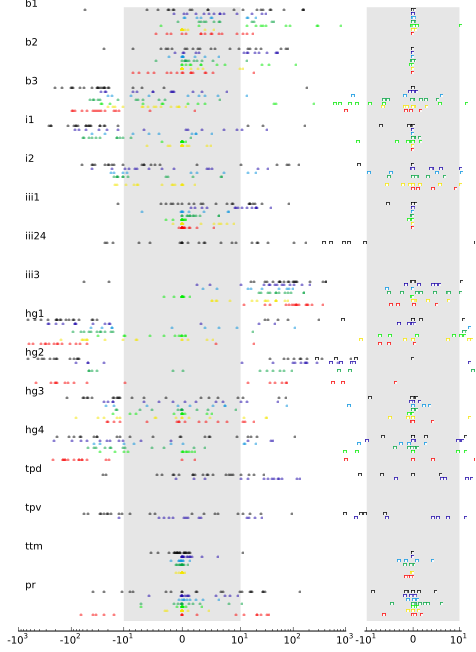

In [99]:
make_stats_summary(peak_dict = peak_dict_amp)

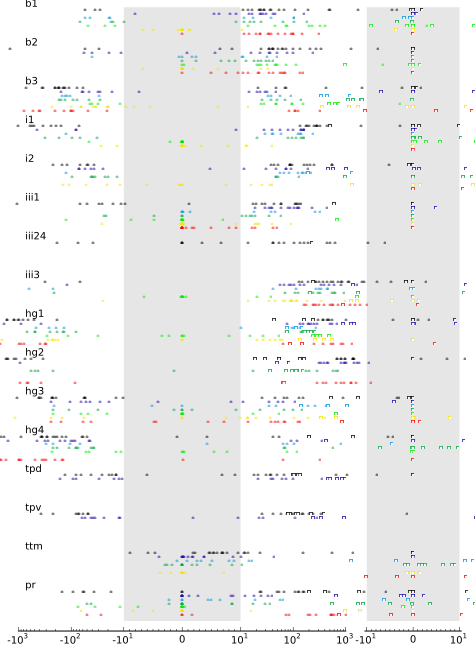

In [100]:
make_stats_summary(peak_dict = peak_dict_freq)

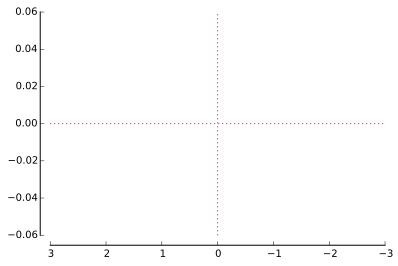

In [313]:
md2,ub2,lb2 = plot_xcovf(cov_db_amp['GMR31E10']['hg4'],color = 'r')
#md2,ub2,lb2 = plot_xcovf(cov_db_amp[gmrlines[0]]['hg4'],color = 'k')
gca().set_xbound(-3,3)
savefig('xcov_funcs_examples_hg.pdf')

In [318]:
gmrlines

['GMR22H05',
 'GMR10A12',
 'GMR74F03',
 'GMR75B06',
 'GMR29E05',
 'GMR31E10',
 'GMR39E01']

In [326]:
np.array(cov_db_amp['GMR29E05']['hg2'])

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

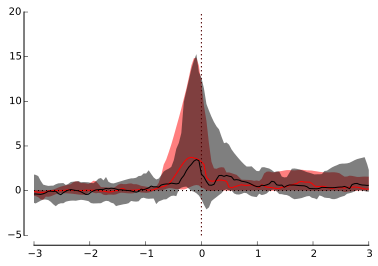

In [327]:
md2,ub2,lb2 = plot_xcovf(cov_db_amp['GMR29E05']['b2'],color = 'r')
md2,ub2,lb2 = plot_xcovf(cov_db_amp[gmrlines[0]]['b2'],color = 'k')
gca().set_xbound(-3,3)
savefig('xcov_funcs_examples_b2.pdf')

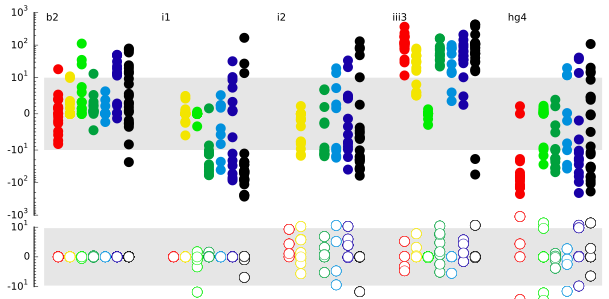

In [267]:
make_stats_summary_transpose(peak_dict = peak_dict_amp,muscle_list = ['b2','i1','i2','iii3','hg4'],ms = 10)
savefig('xcov_values_examples.pdf')

In [229]:
import scipy.signal

In [227]:
def butter_bandpass(lowcut, highcut, sampling_period, order=5):
    import scipy.signal
    sampling_frequency = 1.0/sampling_period
    nyq = 0.5 * sampling_frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, sampling_period, order=5):
    import scipy.signal
    b, a = butter_bandpass(lowcut, highcut, sampling_period, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

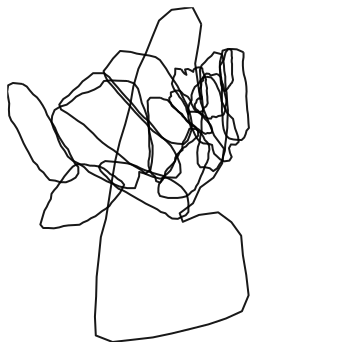

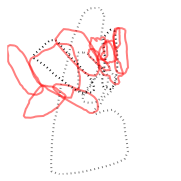

In [331]:
import muscle_model as mm
import tifffile
fig = figure(figsize = (10,10))
#imfile = tifffile.TiffFile('muscle_viz.tiff')
#sumimg = imfile.asarray()

import cPickle as cpkl
f= open('../muscle_segmentation/model_data.cpkl','rb')
model_data = cpkl.load(f)
f.close()

###add position of large setae 
model_data['e1'] = np.array([[ 170.02788104,  326.71685254],
                             [ 380.98203222,  919.92627014]])
model_data['e2'] = array([[ 172.83333333,  332.83333333],
                          [ 551.5       ,  164.83333333]])
e1 = model_data['e1']
e2 = model_data['e2']
muscles = dict()

for key in model_data.keys():
    if not(key in ['e1','e2']):
        muscles[key] = model_data[key]
        
confocal_frame = mm.Frame()
confocal_frame['a1'] = e2[1]-e2[0]
confocal_frame['a2'] = e1[1]-e2[0]
confocal_frame['p'] = e2[0]

#construct a geometric model object from the muscle contours
thorax = mm.GeometricModel(muscles,confocal_frame)

#imshow(sumimg)

#now use the ModelView object to plot the contours on the image
thorax_view = mm.ModelViewMPL(thorax)
contour_kwargs_22H05 = {'b1':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'b2':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'b3':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'i1':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'i2':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'iii1':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'iii24':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'iii3':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'hg1':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'hg2':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'hg3':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'hg4':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'tpv':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'tpd':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'ttm':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'pr':{'edgecolor': 'k', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.9} }

contour_kwargs_10A12 = {'b1':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'b2':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'b3':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'i1':{'edgecolor': 'k', 'linestyle':'dotted','linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'i2':{'edgecolor': 'k', 'linestyle':'dotted','linewidth': 2.0, 'facecolor': 'none','alpha':0.9},
                  'iii1':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'iii24':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'iii3':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'hg1':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'hg2':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'hg3':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'hg4':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'tpv':{'edgecolor': 'k', 'linestyle':'dotted','linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'tpd':{'edgecolor': 'k', 'linestyle':'dotted','linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'ttm':{'edgecolor': 'k', 'linestyle':'dotted','linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'pr':{'edgecolor': 'r', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5} }
figure(figsize = (6,6))#subplot(2,1,1)
thorax_view.plot(thorax.frame,contour_kwargs = contour_kwargs_22H05)
gca().axis('tight');kill_spines()
savefig('expression_illustration.pdf')
figure(figsize = (3,3))#subplot(2,1,1)
thorax_view.plot(thorax.frame,contour_kwargs = contour_kwargs_10A12)
gca().axis('tight');kill_spines()
savefig('expression_illustration_31E10.pdf')
#savefig('model_view.pdf')